# Lab | Making predictions with logistic regression

#### In this lab, you will be using the Sakila database of movie rentals.
#### In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

### 1. Importing libraries

In [1]:
import sqlalchemy
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


### 2. Establishing the connection with MySQL and getting a Panda's dataframe (df) called "data" out of a MySQL query

In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

##### 1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.
##### 2. Read the data into a Pandas dataframe.

In [3]:
query1 = 'select c.title, c.release_year, e.name as category, b.store_id \
            from sakila.rental as a \
join sakila.inventory as b on b.inventory_id = a.inventory_id \
join sakila.film as c on c.film_id = b.film_id \
join sakila.film_category as d on d.film_id = c.film_id \
join sakila.category as e on e.category_id = d.category_id \
group by title \
order by title;'

data_query1 = pd.read_sql_query(query1, engine)
data_query1.head()

,title,release_year,category,store_id
0,ACADEMY DINOSAUR,2006,Documentary,1
1,ACE GOLDFINGER,2006,Horror,2
2,ADAPTATION HOLES,2006,Documentary,2
3,AFFAIR PREJUDICE,2006,Horror,1
4,AFRICAN EGG,2006,Family,2


In [4]:
query2 = 'SELECT a.title, a.film_id, COUNT(c.rental_date) as amount_rented_may from sakila.film AS a \
LEFT JOIN sakila.inventory AS b \
ON a.film_id = b.film_id \
LEFT JOIN sakila.rental AS c \
ON c.inventory_id = b.inventory_id \
where rental_date >= 20050501 and rental_date <= 20050531 \
group by a.film_id \
order by film_id;'

data_query2 = pd.read_sql_query(query2, engine)
data_query2.head()

,title,film_id,amount_rented_may
0,ACADEMY DINOSAUR,1,2
1,AFFAIR PREJUDICE,4,1
2,AFRICAN EGG,5,1
3,AGENT TRUMAN,6,2
4,AIRPORT POLLOCK,8,2


In [5]:
query3 = 'SELECT a.title, a.film_id, COUNT(c.rental_date) as amount_rented_june, \
case \
    when count(rental_date) > 0 then 1 \
    else 0 \
end as "rented_june" \
from sakila.film AS a \
LEFT JOIN sakila.inventory AS b ON a.film_id = b.film_id \
LEFT JOIN sakila.rental AS c ON c.inventory_id = b.inventory_id \
where rental_date >= 20050601 and rental_date <= 20050630 \
group by a.film_id \
order by film_id;' 

data_query3 = pd.read_sql_query(query3, engine)
data_query3.head()

,title,film_id,amount_rented_june,rented_june
0,ACADEMY DINOSAUR,1,3,1
1,ADAPTATION HOLES,3,1,1
2,AFFAIR PREJUDICE,4,2,1
3,AFRICAN EGG,5,2,1
4,AGENT TRUMAN,6,3,1


#### Re-arranging dataframe

In [6]:
import functools 

data_frames = [data_query1, data_query2, data_query3]
data_merge = functools.reduce(lambda  left,right: pd.merge(left,right,on=['title'], how='outer'), data_frames)
data_merge

,title,release_year,category,store_id,film_id_x,amount_rented_may,film_id_y,amount_rented_june,rented_june
0,ACADEMY DINOSAUR,2006,Documentary,1,1.0,2.0,1.0,3.0,1.0
1,ACE GOLDFINGER,2006,Horror,2,NaN,NaN,NaN,NaN,NaN
2,ADAPTATION HOLES,2006,Documentary,2,NaN,NaN,3.0,1.0,1.0
3,AFFAIR PREJUDICE,2006,Horror,1,4.0,1.0,4.0,2.0,1.0
4,AFRICAN EGG,2006,Family,2,5.0,1.0,5.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...
953,YOUNG LANGUAGE,2006,Documentary,1,NaN,NaN,996.0,1.0,1.0
954,YOUTH KICK,2006,Music,1,NaN,NaN,997.0,1.0,1.0
955,ZHIVAGO CORE,2006,Horror,2,998.0,1.0,998.0,2.0,1.0
956,ZOOLANDER FICTION,2006,Children,1,999.0,1.0,999.0,2.0,1.0


#### Fill NaN in amount_rented_may, amount_rented_june and rented_june with 0

In [7]:
data_merge[['amount_rented_may', 'amount_rented_june', 'rented_june']] = data_merge[['amount_rented_may', 'amount_rented_june', 'rented_june']].fillna(0)

data_merge.head()

,title,release_year,category,store_id,film_id_x,amount_rented_may,film_id_y,amount_rented_june,rented_june
0,ACADEMY DINOSAUR,2006,Documentary,1,1.0,2.0,1.0,3.0,1.0
1,ACE GOLDFINGER,2006,Horror,2,NaN,0.0,NaN,0.0,0.0
2,ADAPTATION HOLES,2006,Documentary,2,NaN,0.0,3.0,1.0,1.0
3,AFFAIR PREJUDICE,2006,Horror,1,4.0,1.0,4.0,2.0,1.0
4,AFRICAN EGG,2006,Family,2,5.0,1.0,5.0,2.0,1.0


In [27]:
data_merge.isna().sum()

title                   0
release_year            0
category                0
store_id                0
film_id_x             331
amount_rented_may       0
film_id_y              58
amount_rented_june      0
rented_june             0
dtype: int64

#### I suspect that all films were released in the same year, so I check! If so, I will drop the column.

In [9]:
data_merge['release_year'].value_counts()

2006    958
Name: release_year, dtype: int64

In [11]:
data_merge.shape

(958, 9)

In [49]:
data_drop = data_merge.drop(['film_id_x', 'film_id_y', 'release_year'], axis=1)
data_drop.head()

,title,category,store_id,amount_rented_may,amount_rented_june,rented_june
0,ACADEMY DINOSAUR,Documentary,1,2.0,3.0,1.0
1,ACE GOLDFINGER,Horror,2,0.0,0.0,0.0
2,ADAPTATION HOLES,Documentary,2,0.0,1.0,1.0
3,AFFAIR PREJUDICE,Horror,1,1.0,2.0,1.0
4,AFRICAN EGG,Family,2,1.0,2.0,1.0


In [50]:
data_drop.describe()

,store_id,amount_rented_may,amount_rented_june,rented_june
count,958.000000,958.000000,958.000000,958.000000
mean,1.207724,1.036534,2.412317,0.939457
std,0.405890,0.987763,1.385148,0.238614
min,1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000,1.000000
75%,1.000000,2.000000,3.000000,1.000000
max,2.000000,5.000000,7.000000,1.000000


In [51]:
data_drop.shape

(958, 6)

In [52]:
data_drop['title'].value_counts()
# All titles are unique. 

UNCUT SUICIDES            1
SASSY PACKER              1
STAGE WORLD               1
TELEMARK HEARTBREAKERS    1
REIGN GENTLEMEN           1
                         ..
GROSSE WONDERFUL          1
ANNIE IDENTITY            1
CHAMPION FLATLINERS       1
PRIMARY GLASS             1
TITANIC BOONDOCK          1
Name: title, Length: 958, dtype: int64

In [53]:
data = data_drop.set_index(data_drop['title'])

data = data.drop(['title'], axis=1)

In [54]:
data.head()

,category,store_id,amount_rented_may,amount_rented_june,rented_june
title,,,,,
ACADEMY DINOSAUR,Documentary,1,2.0,3.0,1.0
ACE GOLDFINGER,Horror,2,0.0,0.0,0.0
ADAPTATION HOLES,Documentary,2,0.0,1.0,1.0
AFFAIR PREJUDICE,Horror,1,1.0,2.0,1.0
AFRICAN EGG,Family,2,1.0,2.0,1.0


##### 3. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

#### Check data types

In [55]:
data.dtypes

category               object
store_id                int64
amount_rented_may     float64
amount_rented_june    float64
rented_june           float64
dtype: object

#### Check NA's

In [56]:
data.isna().sum()

category              0
store_id              0
amount_rented_may     0
amount_rented_june    0
rented_june           0
dtype: int64

#### Checking correlation

In [57]:
data.corr()
# amount_rented_may and amount_rented_june are highly correlated, which makes sense. 
# but we keep both columns because they add valuable information

,store_id,amount_rented_may,amount_rented_june,rented_june
store_id,1.000000,-0.193572,-0.319772,-0.161318
amount_rented_may,-0.193572,1.000000,0.616000,0.266533
amount_rented_june,-0.319772,0.616000,1.000000,0.442341
rented_june,-0.161318,0.266533,0.442341,1.000000


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

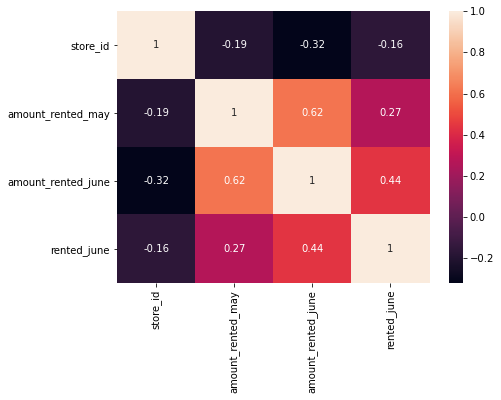

In [59]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(7, 5))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

#### Checking Distributions of numerical columns

C:\Users\yelam\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


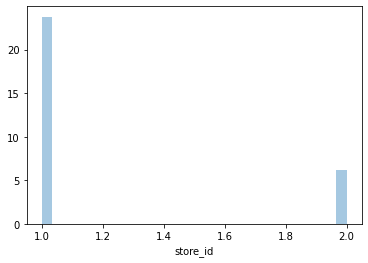

In [60]:
sns.distplot(data['store_id'])
plt.show()

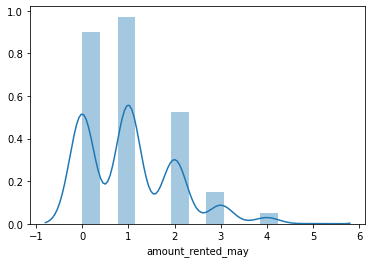

In [61]:
sns.distplot(data['amount_rented_may'])
plt.show()

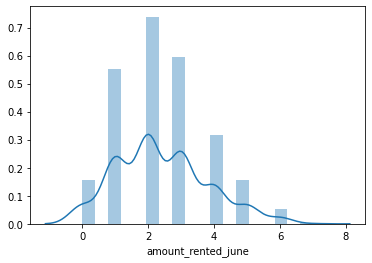

In [62]:
sns.distplot(data['amount_rented_june'])
plt.show()

C:\Users\yelam\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


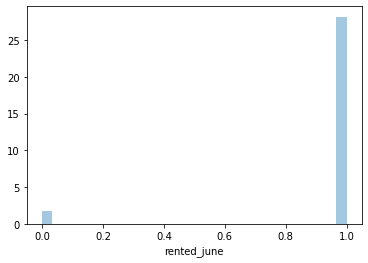

In [63]:
sns.distplot(data['rented_june'])
plt.show()

#### Checking to see if I have to scale the data. Not the case, all values are quite similar.

In [64]:
data

,category,store_id,amount_rented_may,amount_rented_june,rented_june
title,,,,,
ACADEMY DINOSAUR,Documentary,1,2.0,3.0,1.0
ACE GOLDFINGER,Horror,2,0.0,0.0,0.0
ADAPTATION HOLES,Documentary,2,0.0,1.0,1.0
AFFAIR PREJUDICE,Horror,1,1.0,2.0,1.0
AFRICAN EGG,Family,2,1.0,2.0,1.0
...,...,...,...,...,...
YOUNG LANGUAGE,Documentary,1,0.0,1.0,1.0
YOUTH KICK,Music,1,0.0,1.0,1.0
ZHIVAGO CORE,Horror,2,1.0,2.0,1.0


#### I get dummies from categorical columns

In [65]:
import numpy as np

data_final = pd.get_dummies(data)
#cat = data.select_dtypes(include = np.object)
#categorical = pd.get_dummies(cat, columns=['category'], drop_first=True)

data_final

,store_id,amount_rented_may,amount_rented_june,rented_june,category_Action,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
title,,,,,,,,,,,,,,,,,,,,
ACADEMY DINOSAUR,1,2.0,3.0,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
ACE GOLDFINGER,2,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
ADAPTATION HOLES,2,0.0,1.0,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
AFFAIR PREJUDICE,1,1.0,2.0,1.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
AFRICAN EGG,2,1.0,2.0,1.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YOUNG LANGUAGE,1,0.0,1.0,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
YOUTH KICK,1,0.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
ZHIVAGO CORE,2,1.0,2.0,1.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


##### 5. Create a logistic regression model to predict this variable from the cleaned data.

In [66]:
y = data_final['rented_june']
X = data_final.drop(['rented_june'], axis=1)

#### Data partition

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

In [68]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)
predictions = clf.predict(X_test)

In [69]:
# turning my results into a dataframe just to make sense of it
my_df = pd.DataFrame(X_test).copy()
my_df['predictions'] = predictions
my_df['rented_june'] = y_test

In [70]:
my_df

,store_id,amount_rented_may,amount_rented_june,category_Action,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,...,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel,predictions,rented_june
title,,,,,,,,,,,,,,,,,,,,,
TEXAS WATCH,1,0.0,0.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0.0,0.0
JADE BUNCH,2,3.0,3.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1.0,1.0
DISTURBING SCARFACE,1,2.0,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1.0,1.0
HARDLY ROBBERS,1,0.0,0.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0.0,0.0
MUMMY CREATURES,1,0.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YENTL IDAHO,1,1.0,3.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1.0,1.0
WATCH TRACY,1,1.0,2.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,1.0
GUNFIGHTER MUSSOLINI,1,0.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1.0,1.0


##### 6. Evaluate the results.

In [73]:
predictions = clf.predict(X_test)


print("The accuracy of the model is: %4.2f" % (clf.score(X_test, y_test)))


The accuracy of the model is: 1.00


In [74]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

cm = confusion_matrix(y_test, predictions)

Confussion matrix



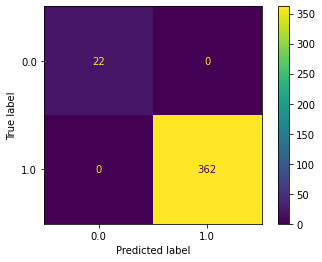

In [75]:
print("Confussion matrix")
plot_confusion_matrix(clf, X_test, y_test) 
print()

In [80]:
# Calculating the accuracy manually
sum(my_df['rented_june']) / sum(my_df['predictions']) 

1.0

In [83]:
from sklearn.metrics import accuracy_score
print('Accuracy score is: ', accuracy_score(y_test, predictions))


Accuracy score is:  1.0


In [85]:
from sklearn.metrics import cohen_kappa_score
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y_test, predictions)))

The Kappa of your model is: 1.00


In [90]:
y.value_counts()

1.0    900
0.0     58
Name: rented_june, dtype: int64

### The model is 100% accurate, showing that there is clearly an error. Is it possible that I used the real results to predict the same results?